### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor


VERBOSE = 1
CV = 4#[(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-26 16:30:39.614507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 16:30:41.182667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 4

hyperparameterspace = {
    'epochs': ["interval-int", 1, 15],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.1],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233211, 359935, 359952, 359931, 359949, 359938]
#[359940, 317614, 359934, 359946, 359932, 233214, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=42)

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=40, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model


        kfold = KFold(n_splits=CV)

        X = dataset.get_X_train().tolist() + dataset.get_X_validation().tolist()
        Y = dataset.get_Y_train().tolist() + dataset.get_Y_validation().tolist()
        
        if TESTING:
            X += dataset.get_X_test().tolist()
            Y += dataset.get_Y_test().tolist()

        X = np.array(X)
        Y = np.array(Y)

        split = (kfold.split(X, Y))

        values = []

        for i, (train_index, test_index) in enumerate(split):
            X_train = X[train_index]
            Y_train = Y[train_index]

            X_val = X[test_index]
            Y_val = Y[test_index]


            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

            Y_predicted = model.predict(X_val)
            error = sklearn.metrics.mean_squared_error(Y_predicted, Y_val)
            values.append(error)

            K.clear_session()
            del model

        result = sum(values)/len(values)
        return result


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = 40 # int(params[3])

        number_of_layers = 1 # int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = 40 # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = 1 # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
            

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1) ** 3
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()
        del model

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()
        del model 

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = m

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(blackboxfunction(best_params))
        #TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="rprop")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        #TESTING = False

        SPARSE_COST.append(result[2])
        SPARSE_COST_OPTIMIZED.append(result[2])

        K.clear_session()


        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)
    


######################################################################################################################################################
Current Dataset: 1 of 6 with id: 233211

################################################## Current Budget: 1 ##################################################
Performing grid search
Fitting 4 folds for each of 1 candidates, totalling 4 fits


2023-04-26 16:30:45.193532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Best params found by grid search:
{'batch_size': 105, 'epochs': 8, 'optimizer__learning_rate': 9.999999999999991e-05}
Performing random search
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best params found by random search:
{'batch_size': 115, 'epochs': 9, 'optimizer__learning_rate': 1.7999689520350208e-05}
Performing bayesian optimization
Iterations took 8.551898535999499 seconds
With Hyperparameters: 
epochs: 4.0
batch_size: 139.0
optimizer__learning_rate: 2.505451432693481e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 18778ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
16.44475607358894
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 9.999999999999999e-05


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 157.9871790920024 seconds
With Hyperparameters: 
epochs: 3.0
batch_size: 93.0
optimizer__learning_rate: 5.916157171822125e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 137400ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.15454744800128495
Optimizing (Rprop)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
1175.5360789594627
Resulting loss (Optimal point evaluated):
837.6607557504922
[0.38944304, 0.13822246]
[0.7142155, 0.14801298]
[448.8576112198841, 571.9750133165622]
[13.262259488517723, 0.13943733476742629]
[15.213252041739953, 966.0719167276004]

################################################## Curre

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 675.594957723999 seconds
With Hyperparameters: 
epochs: 14.0
batch_size: 103.0
optimizer__learning_rate: 1.2619255073401134e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 551555ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
0.07626023281422256
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0
batch_size: 200.0
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
676.5317664156938
Resulting loss (Optimal point evaluated):
449.55586577368234
[0.38944304, 0.13822246, 0.049363755]
[0.7142155, 0.14801298, 0.031016063]
[448.8576112198841, 571.9750133165622, 895.3423896041907]
[13.262259488517723, 0.13943733476742629, 0.0651737231941793]
[15.213252041739953, 966.07191

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 1854.711852454997 seconds
With Hyperparameters: 
epochs: 5.835138776680509
batch_size: 121.11858291452468
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 1242514ms.
Solving linear system (automatic method)...
Done in 2ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.042169650342858224
Resulting loss:
0.05367818410418978
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 8.000000339851823
batch_size: 105.00000189448264
optimizer__learning_rate: 0.042169650342858224
Resulting loss (Optimal value from optimization):
3141.1772805499063
Resulting loss (Optimal point evaluated):
874.4529042253149
[0.38944304, 0.13822246, 0.049363755, 0.05504315]
[0.7142155, 0.14801298, 0.031016063, 0.035751417]
[448.8576112198841, 571.9750133165622, 895.3423896041907, 1078.0305973779857]
[13.26225

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 829.4018854880014 seconds
With Hyperparameters: 
epochs: 12.0
batch_size: 163.0
optimizer__learning_rate: 2.3241768901180124e-06
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 607633ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.042169650342858224
Resulting loss:
0.5362605015312143
Optimizing (Rprop)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 9.750000225982394
batch_size: 104.99999942963468
optimizer__learning_rate: 0.042169650342858224
Resulting loss (Optimal value from optimization):
553.8394701176775
Resulting loss (Optimal point evaluated):
787.6090056093833
[0.38944304, 0.13822246, 0.049363755, 0.05504315, 7.817007, 2.2707765, 2.9095027, 2.5306435, 1.9589413, 1.2006004, 0.92601645, 0.7374463]
[0.7142155, 0.14801298, 0.031016063, 0.035751417, 3.128658, 1

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 218.41847899998902 seconds
With Hyperparameters: 
epochs: 11.444174153115409
batch_size: 163.72240835272552
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 157527ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.0
batch_size: 105.0
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
0.41424510954408333
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 8.874999871826173
batch_size: 81.25000296874995
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
2215.2050655139465
Resulting loss (Optimal point evaluated):
1609.9246696376408
[0.38944304, 0.13822246, 0.049363755, 0.05504315, 7.817007, 2.2707765, 2.9095027, 2.5306435, 1.9589413, 1.2006004, 0.92601645, 0.7374463, 169.68608, 26.871412, 22.0731, 11.71013, 10.5180

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 526.5379741540091 seconds
With Hyperparameters: 
epochs: 4.269790017806606
batch_size: 46.00967793260566
optimizer__learning_rate: 0.035836259890332865
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 369269ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 11.5
batch_size: 105.0
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
1.4151826947027057
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 11.499999499339022
batch_size: 104.99999999955762
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
1.4151797151636532
Resulting loss (Optimal point evaluated):
1.7052156465937847
[0.38944304, 0.13822246, 0.049363755, 0.05504315, 7.817007, 2.2707765, 2.9095027, 2.5306435, 1.9589413, 1.2006004, 0.92601645, 0.7374463, 169.68608, 26.871412, 22.0731, 11.

[0.38944304, 0.13822246, 0.049363755, 0.05504315, 7.817007, 2.2707765, 2.9095027, 2.5306435, 1.9589413, 1.2006004, 0.92601645, 0.7374463, 169.68608, 26.871412, 22.0731, 11.71013, 10.518015, 1.0953273, 0.5389782, 1.4176172, 24.490631, 15.408993, 42.92439, 13.625256]
[0.7142155, 0.14801298, 0.031016063, 0.035751417, 3.128658, 1.2469479, 1.1511531, 0.8366105, 14.240947, 1.7082797, 0.94792676, 1.0437251, 16.61975, 19.34898, 11.651622, 5.822287, 10.593898, 0.18896794, 0.21459946, 0.32513392, 28.317675, 25.837, 21.983463, 2.3074894]
[448.8576112198841, 571.9750133165622, 895.3423896041907, 1078.0305973779857, 172.78122437328813, 221.3089770457161, 470.54762522787905, 255.90264318014488, 152.630961601711, 235.47712327458464, 197.20562380214454, 397.60980916691454, 361.53673622106754, 439.24650794028025, 412.2817890064133, 163.03739830888443, 2.7740926178304526, 1016.7642513490725, 1740.9963960287732, 984.3441026984135, 106.651277549882, 701.7128801860977, 1195.6288277592757, 7.722743727336599

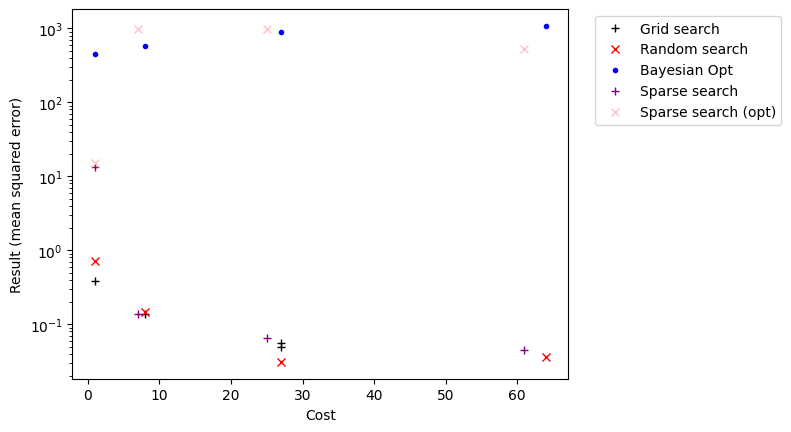

Current dataset: 1 with name id: 359935


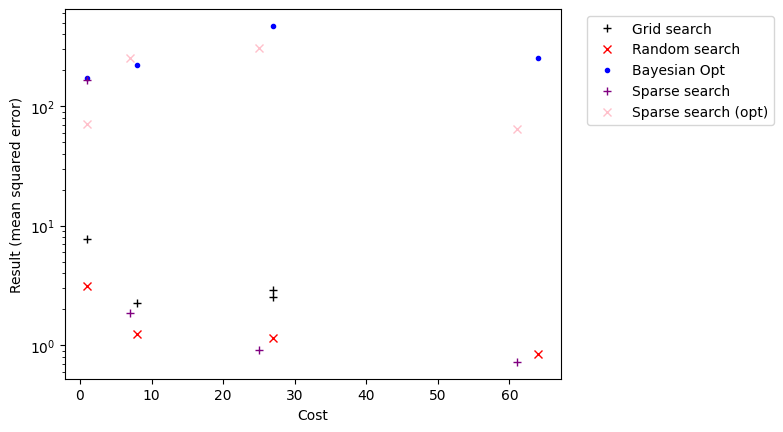

Current dataset: 2 with name id: 359952


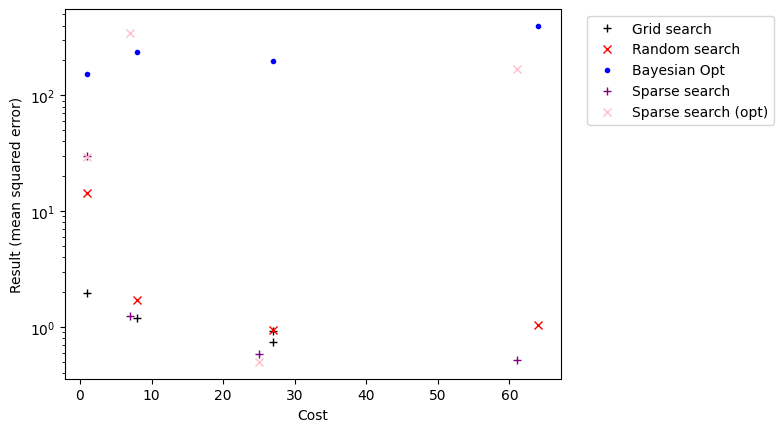

Current dataset: 3 with name id: 359931


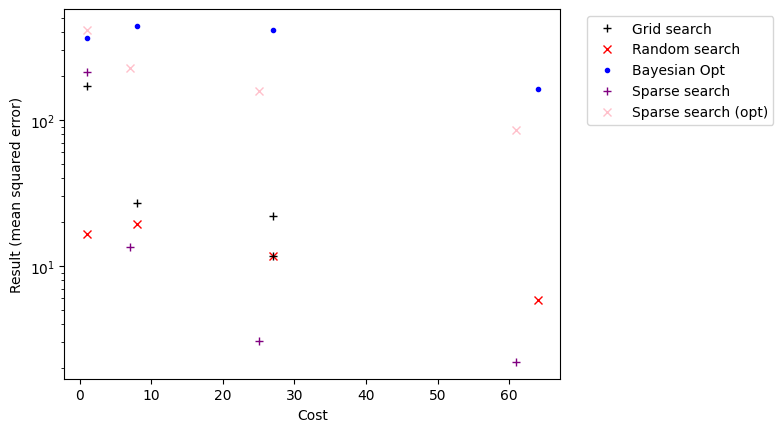

Current dataset: 4 with name id: 359949


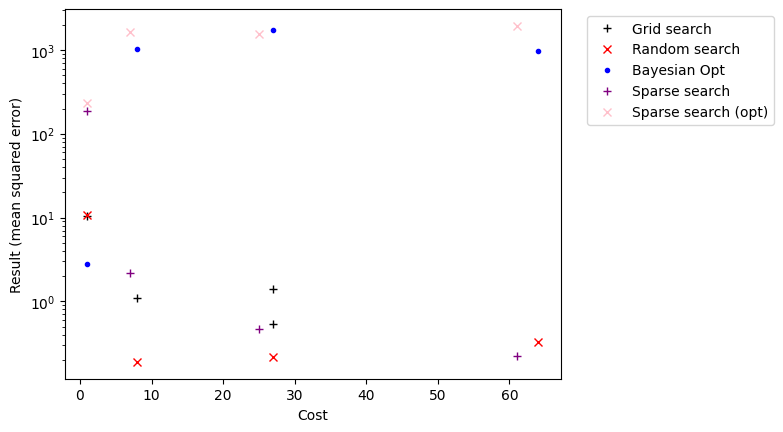

Current dataset: 5 with name id: 359938


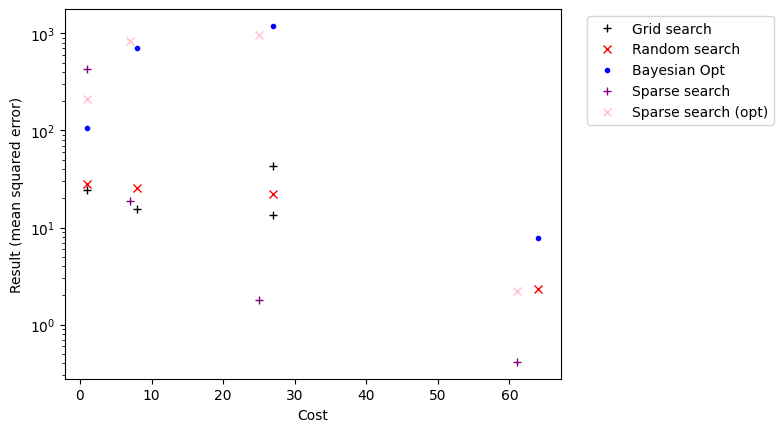

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

